In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from Farm_Evaluator_Vec import *

In [4]:
'''preprocessing to compute AEP'''

# Turbine Specifications.
# -**-SHOULD NOT BE MODIFIED-**-
turb_specs    =  {   
                     'Name': 'Anon Name',
                     'Vendor': 'Anon Vendor',
                     'Type': 'Anon Type',
                     'Dia (m)': 100,
                     'Rotor Area (m2)': 7853,
                     'Hub Height (m)': 100,
                     'Cut-in Wind Speed (m/s)': 3.5,
                     'Cut-out Wind Speed (m/s)': 25,
                     'Rated Wind Speed (m/s)': 15,
                     'Rated Power (MW)': 3
                 }
turb_diam      =  turb_specs['Dia (m)']
turb_rad       =  turb_diam/2 

# turb_coords   =  getTurbLoc(r'..\Shell_Hackathon Dataset\turbine_loc_test.csv')
# power_curve   =  loadPowerCurve('..\Shell_Hackathon Dataset\power_curve.csv')
# wind_inst_freq =  binWindResourceData(r'..\Shell_Hackathon Dataset\Wind Data\wind_data_2007.csv')   
power_curve   =  loadPowerCurve('./power_curve.csv')
wind_inst_freq =  binWindResourceData('./wind_data_2007.csv')   

n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)


def AEP_simp(turb_coords,print_=0):
#     checkConstraints(turb_coords, turb_diam)

    #print('Calculating AEP......')        
    AEP = getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
              n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
    if print_:
        print('Total power produced by the wind farm is: ', "%.12f"%(AEP), 'GWh')
    return AEP

In [12]:
def one_pt_violation(pts,point):
    '''check if adding new point will casue an violation'''
    x,y = point
    if x<50 or x>3950 or y<50 or y>3950:
        return 1
    for x0,y0 in pts:
        if (x0-x)**2 + (y0-y)**2 < 400**2:
            return 1
    return 0

def to_csv(arr,filename='turbinesrand.csv'):
    '''convert the locations into a csv file'''
    df = pd.DataFrame(arr)
    df = df.rename(columns = {0:'x',1:'y'})
    df.to_csv(filename,index=False)

def gen_random_turb_locations():
    '''generate a random configuration that does not violate the constraints'''
    locs = [np.random.randint(size=2,low=50,high=3950)]
    for i in range(49):
        while True:
            point = np.random.randint(size=2,low=50,high=3950)
            if not one_pt_violation(locs,point):
                locs.append(point)
                break
    return np.array(locs)
    
def constraint_violation(pts):
    for i in range(len(pts)):
        x0,y0 = pts[i]
        if x0<50 or x0>3950 or y0<50 or y0>3950:
            return 1
        for j in range(i+1,len(pts)):
            x1,y1 = pts[j]
            if (x0-x1)**2 + (y0-y1)**2 < 400**2:
                return 1
    return 0

def plot_constraint_violations(pts):
    for i in range(len(pts)):
        x0,y0 = pts[i]
        if x0<50 or x0>3950 or y0<50 or y0>3950:
            #plt.scatter(x0,y0,'r')
            print(x0,y0)
        for j in range(i+1,len(pts)):
            x1,y1 = pts[j]
            if (x0-x1)**2 + (y0-y1)**2 < 400**2:
                plt.plot([x0,x1],[y0,y1],'r')

def plot_turbine_locations(locs):
    '''visualize the turbine locations'''
    corners = np.array([[50,0],[50,3950],[3950,50],[3950,3950]])
    pts_list = np.vstack([locs , corners])
    x,y  =  [i[0] for i in pts_list], [i[1] for i in pts_list]
    plt.scatter(x,y)

    plot_constraint_violations(locs)
    plt.show()

In [13]:
def move(turbine_coords,index=0,maxdist=4000,diststep=100):
    '''move a selected turbine to different positions and
    return the max AEP position'''
    tx,ty = turbine_coords[index]
    maxx = (AEP_simp(turbine_coords),tx,ty)
    for dist in range(10,maxdist,diststep):
        #print(dist)
        for drct in np.linspace(0,2*np.pi,36,endpoint=False):
            dx,dy = dist*np.cos(drct), dist*np.sin(drct)
            #print(dx,dy)
            point = [tx + dx, ty + dy]
            if check_inc_violation(turbine_coords[:index],point) or \
                check_inc_violation(turbine_coords[index+1:],point):
                continue
#             turbine_coords[index][0], turbine_coords[index][1] = point
            turbine_coords[index][0], turbine_coords[index][1] = point
            AEP = AEP_simp(turbine_coords)
            #print(AEP)
            if AEP > maxx[0]:
                maxx = (AEP,*point)
    return maxx



In [15]:
#simple_init_configuration
x,y = np.ogrid[50:3950:10j,50:3950:5j]
locs0 = np.array([[i,j] for i in x.ravel() for j in y.ravel()])
# print(x,y,locs0)
del x;del y

In [14]:
locs0 = gen_random_turb_locations()

In [16]:
locs1 = locs0.copy()

In [ ]:
'''try moving each of the turbines'''
for _ in range(3):
    order = np.arange(50)
    np.random.shuffle(order)
    print(_)
    for ind,index in enumerate(order):
        maxAEP,x,y = move(locs1,index,3000,100)
        #maxAEP,x,y = move_sqr(locs1,index,4000,50)
        print(ind,'\t',index,'\t',maxAEP)
        locs1[index] = x,y

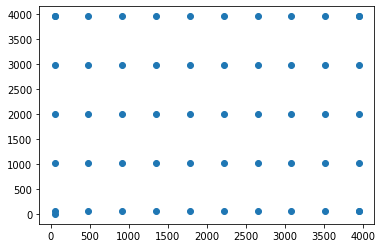

532.5017614746093


In [17]:
plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));#to_csv(locs1,'iter_turb1.csv')

In [ ]:
# to_csv(locs1,'/content/iter_turb3.csv')

In [ ]:
a = np.full((100,2),fill_value=None)
a == None

50
50


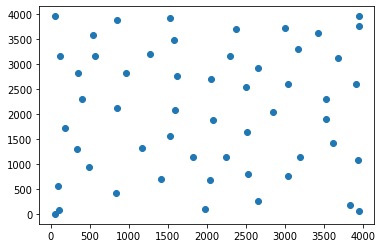

512.67814453125


In [45]:
o1 = organism(rand=True)
locs_2 = o1.get_locs()
print(len(locs_2))
plot_turbine_locations(locs_2);print(AEP_simp(np.array(locs_2)));#to_csv(locs1,'iter_turb1.csv')

In [79]:
class organism(object):
    def __init__(self,rand=False,gene=None,locs100=None):
        if rand:
            self.locs_to_grid(gen_random_turb_locations())
        if not gene is None:    self.gene = gene
        if not locs100 is None: self.locs100 = locs100
        self.get_locs()
    
    def locs_to_grid(self,locs):
        n_seg = 20
        self.locs100 = np.full((n_seg*n_seg,2),fill_value=None)
        self.gene = np.zeros(n_seg*n_seg,dtype=np.int8)
        for x,y in locs:
            xi, yi  = min((x - 50)//195,n_seg -1 ), min((y - 50)//195,n_seg - 1)
            ii = n_seg*xi + yi #bijective hash function for each point to a grid
            # print(x,y,xi,yi,ii)
            self.locs100[ii] = [x,y]
            self.gene[ii]    = 1

    def get_locs(self):
        self.locs = self.locs100[self.gene==1]
        return self.locs

    def mutate_gene(self,_copy=True):
        while True:
            index = np.random.randint(0,50)
            dist  = np.random.randint(0,4000)
            drct  = np.random.randint(0,360)*np.pi/180
            dx,dy = dist*np.cos(drct), dist*np.sin(drct)
            point = [self.gene[index][0]+dx,self.gene[index][1]+dy]
            if check_inc_violation(self.gene[:index],point) or \
                check_inc_violation(self.gene[index+1:],point):
                continue
            
            if _copy:
                gene = self.gene.copy()
                gene[index] = point
                return organism(gene=gene)
    
    def crossover(self,other):
        gene1 = self.gene
        gene2 = other.gene

        l = [[] for i in range(4)]
        for ind,(g1,g2) in enumerate(zip(gene1,gene2)):
            l[g1 + 2*g2].append(ind)
        
        l1, l2  = l[1]   , l[2]
        ll1,ll2 = len(l1), len(l2)
        li1,li2 = ll1 - (ll1>>1), ll2 - (ll2>>1)
        np.random.shuffle(l1)
        np.random.shuffle(l2)
        g1,g2 = gene1.copy(), gene2.copy()
        g1[l1[:li1]] = 0; g2[l2[:li2]] = 0
        g2[l1[:li1]] = 1; g1[l2[:li2]] = 1

        locs100_1 = np.full((400,2),fill_value=None)
        locs100_2 = np.full((400,2),fill_value=None)

        ii1, ii2 = self.locs100 != None, other.locs100 != None
        locs100_1[ii1] = self.locs100[ii1]
        locs100_1[ii2] = other.locs100[ii2]

        locs100_2[ii2] = other.locs100[ii2]
        locs100_2[ii1] = self.locs100[ii1]

        # print(ii1.sum(),ii2.sum(),ii2.shape,(locs100_1!=None).sum())
        
        return (organism(rand=False,gene=g1,locs100=locs100_1),
                organism(rand=False,gene=g2,locs100=locs100_2) )
    
    def crossover2(self,other):
        while True:
            o1,o2 = self.crossover(other)
            if not constraint_violation(o1.locs):    return o1
            if not constraint_violation(o2.locs):    return o2


In [ ]:
o1,o2 = [organism(rand=True) for i in range(2)]
print(len(o1.get_locs()))
print(len(o2.get_locs()))
o3 = o1.crossover2(o2)
print(o3.locs)
print(constraint_violation(o3.locs))
# print(constraint_violation(o4.locs))
print(checkConstraints(o3.locs, 100))
# print(len(o3.get_locs()))
# o5 = o1.mutate_gene()
# print(len(o5.get_locs()))

50
50


In [ ]:
# locs_2 = organism().get_locs()
locs_2 = o3.get_locs()
print(len(locs_2),locs_2.shape)
plot_turbine_locations(locs_2);print(AEP_simp(np.array(locs_2)));#to_csv(locs1,'iter_turb1.csv')